In [235]:
%matplotlib inline

import time
import functools
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import scipy
import scipy.sparse as sparse
import matplotlib.pyplot as plt
from numpy import linalg, dot, array


from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from nltk.corpus import stopwords
from sklearn.naive_bayes import BernoulliNB
from sklearn import linear_model
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import recall_score
from sklearn.model_selection import train_test_split


##binary classification of comp and rec
categories = ['comp.graphics','comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware','rec.autos', 'rec.motorcycles','rec.sport.baseball','rec.sport.hockey']
eight_train = fetch_20newsgroups(subset='train',categories=categories, shuffle=True, random_state=42)
eight_test = fetch_20newsgroups(subset='test',categories=categories, shuffle=True, random_state=42)


In [236]:
eight_train.target_names

['comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey']

In [237]:
set(eight_train.target)

{0, 1, 2, 3, 4, 5, 6, 7}

(array([ 591.,  590.,  578.,  594.,  598.,  597.,  600.]),
 array([1, 2, 3, 4, 5, 6, 7, 8]),
 <a list of 7 Patch objects>)

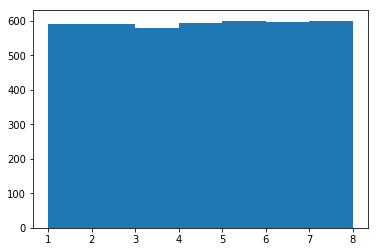

In [238]:
plt.hist(eight_train.target,bins=[1,2,3,4,5,6,7,8])

(array([ 394.,  392.,  385.,  396.,  398.,  397.,  399.]),
 array([1, 2, 3, 4, 5, 6, 7, 8]),
 <a list of 7 Patch objects>)

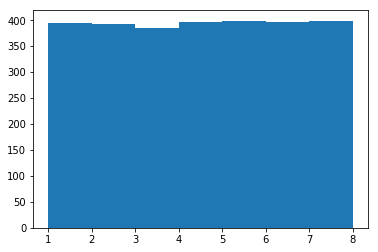

In [239]:
plt.hist(eight_test.target,bins=[1,2,3,4,5,6,7,8])

### preprocessing

In [240]:
lemmatizer = nltk.WordNetLemmatizer()
stop = stopwords.words('english')
stop = stop+(list(string.ascii_lowercase)) + list(string.digits)
translation_punc = str.maketrans(string.punctuation,' '*len(string.punctuation))


In [243]:
def preprocessing(line: str) -> str:
    line = str(line).translate(translation_punc)

    line = nltk.word_tokenize(line.lower())
    
    line = [lemmatizer.lemmatize(t,'v') for t in line if t not in stop]
    return ' '.join(line)

In [244]:
preprocessing('I liked this books1234!!!!! w q g 1 2')

'like books1234'

In [245]:
train_data = list(map(preprocessing, eight_train.data))
test_data = list(map(preprocessing, eight_test.data))

In [299]:
#nltk.word_tokenize(train_data[0])

In [247]:
tokens_train = [word for line in train_data \
               for word in nltk.word_tokenize(line)]

word_features = nltk.FreqDist(tokens_train)
print(word_features)

<FreqDist with 72296 samples and 849170 outcomes>


In [248]:
word_features.most_common(10)

[('ax', 62401),
 ('edu', 8552),
 ('line', 5456),
 ('subject', 4946),
 ('organization', 4708),
 ('max', 4596),
 ('com', 4456),
 ('write', 3677),
 ('get', 3492),
 ('use', 3082)]

In [249]:
topwords = [fpair[0] for fpair in list(word_features.most_common(10000))]

In [250]:
tf_vec = TfidfVectorizer()
tf_fit = tf_vec.fit_transform([' '.join(topwords)])
tf_fit
x_train_tfidf = tf_vec.transform(train_data)
x_train_tfidf
x_test_tfidf = tf_vec.transform(test_data)


In [251]:
tf_vec = TfidfVectorizer()
x_train_tfidf = tf_vec.fit_transform(train_data)
x_test_tfidf = tf_vec.transform(test_data)


In [300]:
#tf_vec.vocabulary_

### Feature Selection LSA

In [289]:
svd = TruncatedSVD(n_components=50, algorithm='randomized', 
            n_iter=5, random_state=42, tol=0.0)

In [293]:
M_train_new = svd.fit_transform(x_train_tfidf)
M_test_new = svd.transform(x_test_tfidf)


In [294]:
M_train_new.shape
M_test_new.shape

(3150, 50)

### SVM

precision:0.978
recall:0.957
accuracy:0.968
confusion matrix:
[[1556   34]
 [  67 1493]]


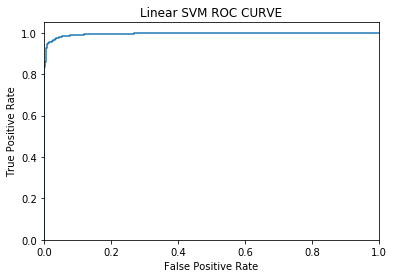

In [295]:
from sklearn import svm

categories1 =['comp.graphics','comp.os.ms-windows.misc','comp.sys.ibm.pc.hardware','comp.sys.mac.hardware']
categories2 =['rec.autos','rec.motorcycles', 'rec.sport.baseball' ,'rec.sport.hockey']

train_target = [];
test_target = [];
for i in eight_train.target:
    if eight_train.target_names[i] in categories1 :
        train_target.append(1);
    else:
        train_target.append(-1);
    
for i in eight_test.target:
    if eight_test.target_names[i] in categories1 :
        test_target.append(1);
    else:
        test_target.append(-1);

clf = svm.LinearSVC(penalty='l2', loss='squared_hinge', dual=True, 
                    tol=0.0001, C=1, multi_class='ovr', fit_intercept=True, 
                    intercept_scaling=1, class_weight=None, verbose=0, 
                    random_state=1, max_iter=1000)
clf.fit(M_train_new, train_target)
m_decision=clf.decision_function(M_test_new)
P = clf.predict(M_test_new)

fpr, tpr, thresholds = metrics.roc_curve(test_target, m_decision)

m_precision = metrics.precision_score(test_target,P)
m_recall = metrics.recall_score(test_target,P)
m_accuracy = metrics.accuracy_score(test_target,P)
m_confusion_matrix = metrics.confusion_matrix(test_target,P)
print ('precision:{0:.3f}'.format(m_precision))
print ('recall:{0:0.3f}'.format(m_recall))
print ('accuracy:{0:0.3f}'.format(m_accuracy))
print ('confusion matrix:\n{}'.format(m_confusion_matrix))

import matplotlib.pyplot as plt

plt.figure()
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Linear SVM ROC CURVE')
plt.show()



### Naive Bayesian

In [221]:
from sklearn.naive_bayes import MultinomialNB
mnb_model = MultinomialNB()
mnb_model
# Train Model
start = time.time()
mnb_model.fit(x_train_tfidf, train_target)
end = time.time()

print("Multinomial NB model trained in %f seconds" % (end-start))
# Predict
pred = mnb_model.predict(x_test_tfidf)
print(pred)

# Metrics
# metrics.accuracy_score(y_true, y_pred)
accuracy = metrics.accuracy_score(pred,test_target)
print(accuracy)

print(metrics.classification_report(y_true=test_target, y_pred=pred))

Multinomial NB model trained in 0.016266 seconds
[ 1  1  1 ..., -1  1  1]
0.976825396825
             precision    recall  f1-score   support

         -1       0.96      0.99      0.98      1590
          1       0.99      0.96      0.98      1560

avg / total       0.98      0.98      0.98      3150



In [200]:
x_train_tfidf.shape

(4732, 45543)

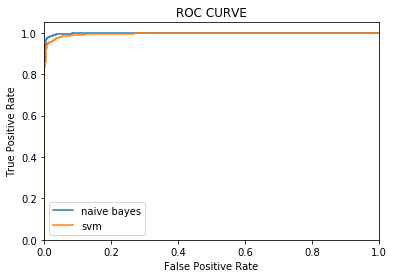

In [298]:
y_score = mnb_model.predict_proba(x_test_tfidf)
fpr2, tpr2, thresholds = metrics.roc_curve(test_target, y_score[:,1])

plt.figure()
plt.plot(fpr2, tpr2,fpr,tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(['naive bayes','svm'])
plt.show()